## Application of Uniform Manifold Approximation and Projection for Data Reduction and Visualization in Spectral Imaging of Artworks

Marc Vermeulen$^{1}$, Kate Smith$^{2}$, Katherine Eremin$^{2}$, Georgina Rayner$^{2}$, and Marc Walton$^{1}$

$^{1}$ Northwestern University / Art Institute of Chicago Center for Scientific Studies in the Arts (NU-ACCESS), 2145 Sheridan Road, Evanston, IL, United States

$^{2}$ Harvard Art Museums, Straus Center for Conservation and Technical Studies, 32 Quincy St, Cambridge, MA, United States



In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import umap 
from PIL import Image, ImageOps
import seaborn as sns
from scipy.optimize import nnls 
from skimage.feature import peak_local_max
import ipywidgets as widgets
from ipywidgets import interactive
from datetime import datetime

# Data formating

### Import spectral image stack, RGB image and associated wavelength
1) Import the spectral data (formatted as ".tif") <br>
2) Import the 8 bit RGB ".tif" image <br>
3) Import the wavelength calibration file (ascii) corresponding to the channels of the spectral stack

The RGB image is calculated from the spectral stack (data cube) using Fiji python scripts provided (refer to the section "1.3. RGB conversion scripts" of the README file) <br>

>User input: indicate file paths

In [4]:
#Spectral data (as a tif file) 
img = Image.open("\\path\\file name.tif")
img.size

(1034, 1538)

In [5]:
#8 bit RGB image (as a tif file)
img_RGB = Image.open("\\path\\file name.tif")
img_RGB.size

if img.size == img_RGB.size:
    print("The RGB image and spectral stack are the same size. Proceed to the next steps")
else:
    print("Something went wrong; The RGB image and spectral stack are not the same size")

The RGB image and spectral stack are the same size. Proceed to the next steps


In [6]:
#calibrated wavelength (usually available from the camera metadata file)
wavelength = (393.35, 395.4374, 397.5248, 399.6122, 401.6996, 403.787, 405.8744, 407.9618, 410.0492, 412.1366, 414.224, 416.3114, 418.3988, 420.4862, 422.5736, 424.661, 426.7484, 428.8358, 430.9232, 433.0106, 435.098, 437.1854, 439.2728, 441.3602, 443.4476, 445.535, 447.6224, 449.7098, 451.7972, 453.8846, 455.972, 458.0594, 460.1468, 462.2342, 464.3216, 466.409, 468.4964, 470.5838, 472.6712, 474.7586, 476.846, 478.9334, 481.0208, 483.1082, 485.1956, 487.283, 489.3704, 491.4578, 493.5452, 495.6326, 497.72, 499.8074, 501.8948, 503.9822, 506.0696, 508.157, 510.2444, 512.3318, 514.4192, 516.5066, 518.594, 520.6814, 522.7688, 524.8562, 526.9436, 529.031, 531.1184, 533.2058, 535.2932, 537.3806, 539.468, 541.5554, 543.6428, 545.7302, 547.8176, 549.905, 551.9924, 554.0798, 556.1672, 558.2546, 560.342, 562.4294, 564.5168, 566.6042, 568.6916, 570.779, 572.8664, 574.9538, 577.0412, 579.1286, 581.216, 583.3034, 585.3908, 587.4782, 589.5656, 591.653, 593.7404, 595.8278, 597.9152, 600.0026, 602.09, 604.1774, 606.2648, 608.3522, 610.4396, 612.527, 614.6144, 616.7018, 618.7892, 620.8766, 622.964, 625.0514, 627.1388, 629.2262, 631.3136, 633.401, 635.4884, 637.5758, 639.6632, 641.7506, 643.838, 645.9254, 648.0128, 650.1002, 652.1876, 654.275, 656.3624, 658.4498, 660.5372, 662.6246, 664.712, 666.7994, 668.8868, 670.9742, 673.0616, 675.149, 677.2364, 679.3238, 681.4112, 683.4986, 685.586, 687.6734, 689.7608, 691.8482, 693.9356, 696.023, 698.1104, 700.1978, 702.2852, 704.3726, 706.46, 708.5474, 710.6348, 712.7222, 714.8096, 716.897, 718.9844, 721.0718, 723.1592, 725.2466, 727.334, 729.4214, 731.5088, 733.5962, 735.6836, 737.771, 739.8584, 741.9458, 744.0332, 746.1206, 748.208, 750.2954, 752.3828, 754.4702, 756.5576, 758.645, 760.7324, 762.8198, 764.9072, 766.9946, 769.082, 771.1694, 773.2568, 775.3442, 777.4316, 779.519, 781.6064, 783.6938, 785.7812, 787.8686, 789.956, 792.0434, 794.1308, 796.2182, 798.3056, 800.393, 802.4804, 804.5678, 806.6552, 808.7426, 810.83, 812.9174, 815.0048, 817.0922, 819.1796, 821.267, 823.3544, 825.4418, 827.5292, 829.6166, 831.704, 833.7914, 835.8788, 837.9662, 840.0536, 842.141, 844.2284, 846.3158, 848.4032, 850.4906, 852.578, 854.6654, 856.7528, 858.8402, 860.9276, 863.015, 865.1024, 867.1898, 869.2772, 871.3646, 873.452, 875.5394, 877.6268, 879.7142, 881.8016, 883.889, 885.9764, 888.0638, 890.1512, 892.2386)

### Dataset preparation prior to data reduction

1) remove any zero pixels artificially produced when stitching together two dissimilarly sized data cubes and unfold image into n x m matrix where n = number of wavelength channels and m =  number of pixels <br>
Running this cell will provide the original shape of the array 

>User input: in "#choose number of channels in spectral stack", indicate number of channels associated with the spectral stack (should correspond to the wavelengths imported in the prior step, default: 240) <br>

2) random selection of pixels to fit capabilities of the computer (can be modified until the shape of the array used to create the embedding (following cell) is deemed appropriate).

>User input: select a percentage of pixels to use: 0.25 for 25%, 1 for 100% (default value: 0.25) <br>

3) selection of the wavelength range to use prior to embedding (allows to remove unwanted - noisy for example - parts of the spectrum). <br>
Runnign this cell (# input the desired spectral range) will provide the shape of the array used to create the embedding. 

> User input: input the spectral range to use (lower/upper)

In [34]:
width, height = img.size #X and Y image dimensions
X_dim = width 
Y_dim = height 

# get the data into a numpy array
images = []
for i in range(img.n_frames):
    img.seek(i)
    images.append(np.array(img)) 
    
# choose number of channels in spectral stack
tot_unfolded =  np.reshape(images,(240,(np.shape(images)[1]*np.shape(images)[2])))

# remove any of the totally zero lines, for when the images is stitched together
f = [i for i, e in enumerate(np.sum(tot_unfolded, axis = 0)) if e != 0]
zeros_removed = tot_unfolded.transpose()[f].transpose()

# slice image from [start: end]
unfolded = zeros_removed.transpose()[0:len(zeros_removed.transpose())].transpose()

np.shape(tot_unfolded)# output dimensions of file

(240, 1590292)

In [8]:
# random selection of pixels (default value: 0.15 - 15% of the pixels)
lists = list(range(np.shape(unfolded)[1]))
k = random.sample(lists, int(len(lists)*0.15))
unfoldedb = unfolded.T[k].T

In [10]:
# input the desired spectral range
lower = 10
upper = 240

def lambda_select(lower,upper,data, wavelength):
    d = data[lower:upper] #[channel begin: channel end]
    w = wavelength[lower:upper]
    return(d,w)

#function returns wavelength range selected for data, d, and wavelength, w.
d,w = lambda_select(lower,upper,unfoldedb,wavelength)

np.shape(d)

(230, 238543)

# Data reduction

### UMAP embedding

Embed high-dimensional data into a 2-dimensional space
<br> (minimum distance and number of components are set by default at 0 and 2 respectively).<br>

>User input <b>
>>1) input the number of neighbors (default: 10) <br>
>>2) input the desired distance metric (default: cosine) <br>
>>3) select or deselect the "random seed state" (by deleting or including the pound (#) sign, unselected by default) <br>

In [11]:
start_time = datetime.now()

embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0,
    n_components=2,
    metric='cosine', 
    #random_state=42
).fit_transform(d.transpose()).transpose()
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:03:40.085535


# Data visualization

### Create sparse UMAP visualization map
Create UMAP X and Y embedding and sample mask. <br>
In the sample mask, the white pixels correspond to the pixels selected through the random selection of pixels. 

>No user input required. Just run the cell.

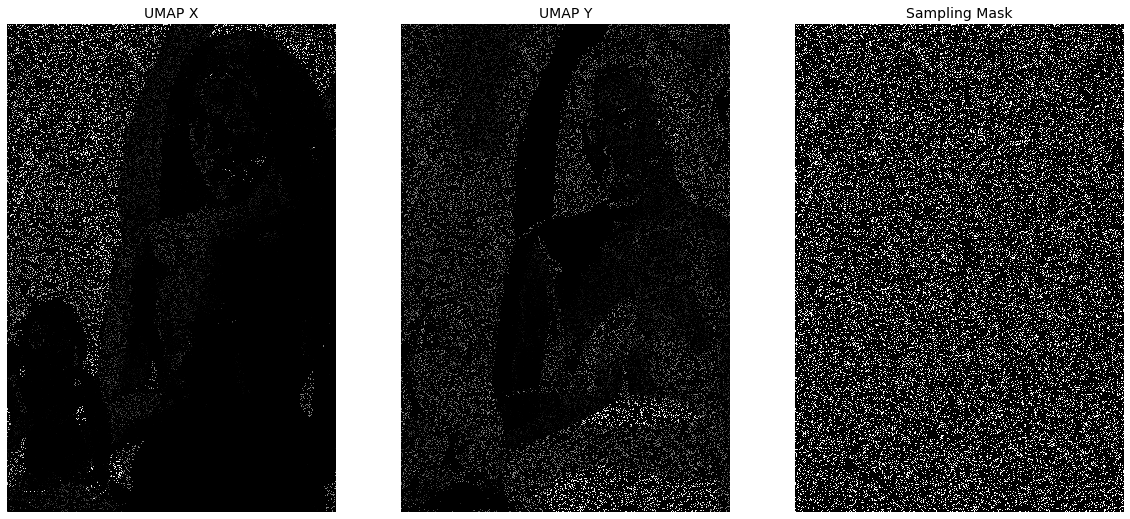

In [30]:
#arrays for UMAP embedding X and embedding Y filled with zeros
TT =  np.zeros(len(unfolded.T))
TT2 = np.zeros(len(unfolded.T))

#placing UMAP embeddings into their indexed position in the array
for i in range(0,len(unfoldedb.T)):
    cas = k[i] 
    TT[cas] = embedding[0][i] 
    TT2[cas] = embedding[1][i]

size = (img.size[0]*img.size[1])
Mask = np.zeros(size)
Mask[k] = 1
Mask = [val*255 for val in Mask]

Mask_new = np.zeros([img.size[1]*img.size[0]])
bod_new = np.zeros([img.size[1]*img.size[0]])
bod2_new = np.zeros([img.size[1]*img.size[0]])

n = -1
for i in range(img.size[1]*img.size[0]):
    if np.sum(tot_unfolded[:, i], axis = 0) != 0 :
        n = n + 1
        Mask_new[i] = Mask[n]
        bod_new[i] = TT[n]
        bod2_new[i] = TT2[n]
    
Mask = np.reshape(Mask_new, (img.size[1],img.size[0])) #.astype('uint8')
bod = np.reshape(bod_new, (img.size[1],img.size[0])) #.astype('float32')
bod2 = np.reshape(bod2_new, (img.size[1],img.size[0])) #.astype('float32')

#visualize results as sparsely sampled image. In "mask", bright points are sampled.
%matplotlib inline 
f, ax = plt.subplots(1,3, figsize=(20,9))
sns.despine(left=True, bottom=True, right=True)

ax[0].set_title('UMAP X', size = 14)
ax[0].imshow(bod,interpolation='nearest',cmap='gray', vmin = 0)
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)

ax[1].set_title('UMAP Y', size = 14)
ax[1].imshow(bod2,interpolation='nearest',cmap='gray', vmin = 0)
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)

ax[2].set_title('Sampling Mask', size = 14)
ax[2].imshow(Mask,interpolation='nearest',cmap='gray', vmin = 0)
ax[2].axes.get_xaxis().set_visible(False)
ax[2].axes.get_yaxis().set_visible(False)

plt.show()

### Create UMAP colored scatterplot

>No user input required. Just run the cell.

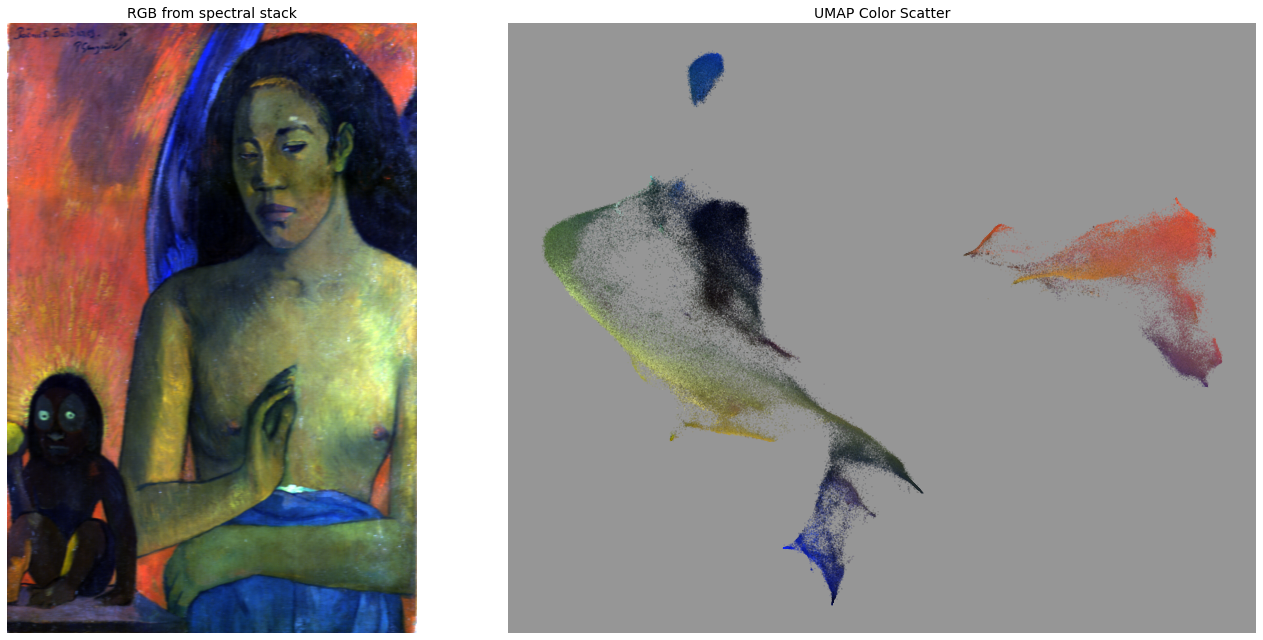

In [13]:
im1 = Image.Image.split(img_RGB)
RGB = []
for i in range(0,3):
    im1[i]
    RGB.append(np.array(ImageOps.fit(im1[i], (X_dim,Y_dim))))

normed_RGB = [val/255 for val in RGB]
sa = np.reshape(normed_RGB,(3, X_dim*Y_dim)).transpose()[k]
ss = sa[0:len(sa)].transpose()

colors = []
for i in range(0, len(ss[0])):
    c = [ss[0][i],ss[1][i],ss[2][i]]
    colors.append(c)
    
%matplotlib inline 
f, ax = plt.subplots(1,2,figsize=(20,9))
sns.despine(left=True, bottom=True, right=True)


ax[0].imshow(img_RGB)
ax[0].set_title('RGB from spectral stack', size = 14)
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)

#Color Scatter
ax[1].set_title('UMAP Color Scatter', size = 14)
ax[1].axes.get_xaxis().set_visible(False) #set X axis 
ax[1].axes.get_yaxis().set_visible(False) #set Y axis
ax[1].set_facecolor((150/255, 150/255, 150/255)) #set gray background if desired
ax[1].scatter(embedding[0],embedding[1], c=colors, s=0.01) 

f.tight_layout()
plt.show()

# Endmember extraction

1) Identify number of endmembers through a 2D histogram algorithm <br>
Running the cell will provide the number of endmembers found <br>
>User input: choose threshold (threshold_rel) and minimum distance (min_distance) values (default: 0.2 and 15 respectively) <br>

2) Plot density map
> No user input required

3) Plot regions selected from the 2D histogram
> No user input required

4) Extract spectral endmembers and plot <br>
Running this cell will indicate the shape of the endmembers (number of channels, number of endmembers)
>No user input required

5) Save endmembers extracted in a csv format
>User input: indicate file path and file name

In [14]:
# Identify number of endmembers using peak finding ("mountain top") in a 2D histogram 
Grid = 256
xmin, xmax = np.amin(embedding[0]), np.amax(embedding[0])
ymin, ymax = np.amin(embedding[1]), np.amax(embedding[1])
counts, xedges, yedges = np.histogram2d(embedding[0], embedding[1], bins=Grid)

#find local maxima in 2D histogram
local_maxi = peak_local_max(counts, indices=True, threshold_rel = 0.2, min_distance = 15, exclude_border = False)

local_max_x = []
local_max_y = []

for i in range(0,len(local_maxi)):
    NewValue_X = (((local_maxi[i][0] ) * (xmax - xmin)) / (Grid - 0)) + xmin
    NewValue_Y = (((local_maxi[i][1] - 0) * (ymax - ymin)) / (Grid - 0)) + ymin
    local_max_x.append(NewValue_X)
    local_max_y.append(NewValue_Y)
    
x = [x for x in zip(local_max_x,local_max_y)]
print(len(x))

21


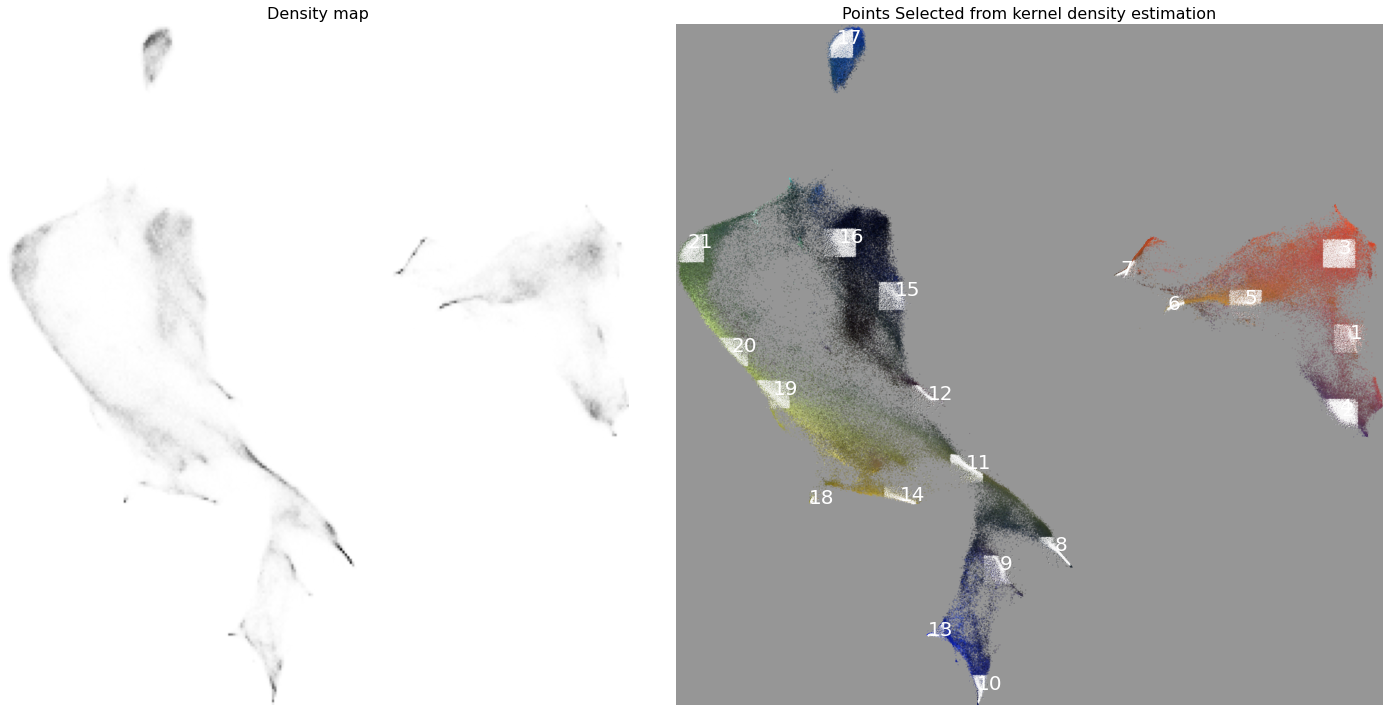

In [16]:
# Plot regions selected from the 2D histogram

min_max = 0.4 #determines bounding box size
points = len(x)
centroid = [] #empty array for selected UMAP centroids
F = [] #indicies of UMAP points

for i in range(0,points):
    
    #set bounding square 
    Minx = x[i][0] - min_max
    Maxx = x[i][0] + min_max
    Miny = x[i][1] - min_max
    Maxy = x[i][1] + min_max
    
    #select points
    z3 = [0 if j == 0 else j for j in [j if j <= Maxx else 0 for j in [j if j >= Minx else 0 for j in embedding[0]]]]
    zz3 = [0 if j == 0 else j for j in [j if j <= Maxy else 0 for j in [j if j >= Miny else 0 for j in embedding[1]]]]
    f = [i for i, e in enumerate([x*y for x,y in zip(z3,zz3)]) if e != 0]
    d = embedding.transpose()[f]
    F.append(f)
    centroid.append(d)
    
%matplotlib inline 
fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.despine(left=True, bottom=True, right=True)

#2D histogram density plot
ax[0].set_title('Density map', size = 16)
ax[0].imshow(np.rot90(counts), cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax[0].set_facecolor((0, 0, 0)) #set gray background
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)

#Color Scatter with sampled pixels
ax[1].set_title('Points Selected from kernel density estimation', size = 16)
ax[1].set_facecolor((150/255, 150/255, 150/255)) #set gray background
ax[1].scatter(embedding[0],embedding[1], c=colors ,s=0.01, alpha=1)
ax[1].set_ylim([ymin, ymax])
ax[1].set_xlim([xmin, xmax])
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)

#Plot pixels used to select endmembers
for i in range(0,len(x)):
    ax[1].scatter(centroid[i].transpose()[0], centroid[i].transpose()[1], color='white', s=0.1, alpha = 0.2)

#Endmembers annotation
label = [val+1 for val in list(range(len(x)))]
centroids = np.array(x).transpose()
    
for i, txt in enumerate(label):
    ax[1].annotate(txt, (centroids[0][i], centroids[1][i]), color='white', size=20)  
fig.tight_layout()
plt.show()

end_members = []

for i in range(0, len(x)):
    jj = np.mean(unfolded.T[k][F[i]], axis = 0)
    end_members.append(jj)
end_members = np.array(end_members).transpose()  

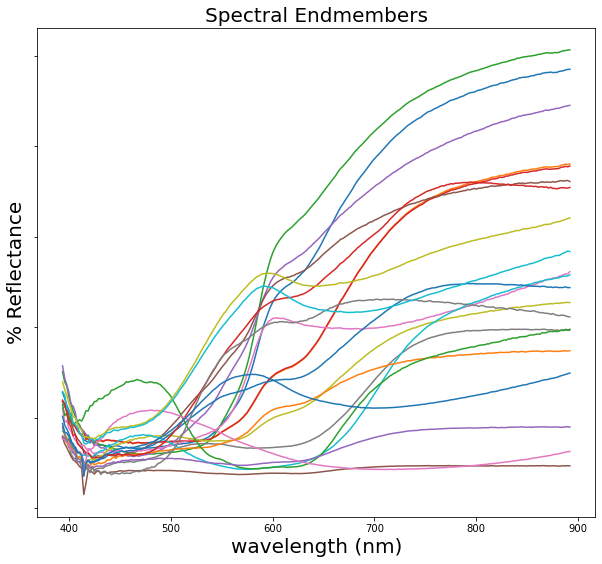

(240, 21)

In [17]:
# Extract spectral endmembers and plot

%matplotlib inline 
fig,ax = plt.subplots(1,figsize=(10,9))
ax.set_title('Spectral Endmembers', size = 20)
ax.plot(wavelength, end_members)
ax.set_ylabel('% Reflectance', size=20)
ax.set_xlabel('wavelength (nm)', size=20)
ax.set_yticklabels([]) # Turn off tick labels

plt.show()
np.shape(end_members)

In [19]:
#Save endmembers extracted in a csv format

np.savetxt('\\path\\file name.csv',end_members,delimiter=' ')

# Endmember distribution

1) Perform non negative least squares fit to whole original data stack <br>
Running this cell will provide with the shape of the analyzed array (number of endmembers, number of pixels in the original data stack)
>No user input required

2) Visualize pigment distribution maps and associated reflectance curve <br>
Running this cell will create an interactive plot. <br>
>User input: Use the slider to visualize the endmember distribution maps.

3) Save pigment distribution maps in a txt format
>User input: indicate file path and file name

In [20]:
# Perform non negative least squares fit to entire original data stack

Ends = np.array([nnls(end_members,i)[0] for i in tot_unfolded.transpose()]).transpose()
np.shape(Ends)

(21, 1590292)

In [21]:
# Visualize pigment distribution maps and associated reflectance curves

End_maps = np.reshape(Ends,(np.shape(Ends)[0],np.shape(images)[1],np.shape(images)[2]))
%matplotlib inline 
def f(ends):
    fig, axarr = plt.subplots(1,3,figsize=(20,10))
    
    axarr[0].imshow(img_RGB)
    axarr[0].set_title('RGB from spectral stack')
    axarr[0].axes.get_xaxis().set_visible(False)
    axarr[0].axes.get_yaxis().set_visible(False)
    
    axarr[1].imshow(End_maps[ends-1], interpolation='nearest',cmap='gray', vmin = 0)
    axarr[1].set_title('endmember ' + str(ends))
    axarr[1].axes.get_xaxis().set_visible(False)
    axarr[1].axes.get_yaxis().set_visible(False)
    
    axarr[2].plot(wavelength, end_members[:,ends-1])
    axarr[2].set_ylabel('% Reflectance', size=20)
    axarr[2].set_xlabel('wavelength (nm)', size=20)
    axarr[2].set_yticklabels([]) # Turn off tick labels
    axarr[2].set_ylim(np.amin(end_members), np.amax(end_members)) #set y limits if desired
   
    plt.show()

interactive_plot = interactive(f, ends=(1, len(end_members.transpose()+1)))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=11, description='ends', max=21, min=1), Output()), _dom_classes=('widget…

In [22]:
#Save pigment distribution maps in a txt format

np.savetxt("\\path\\file name.txt",Ends,delimiter=' ')

# Endmembers sub-selection
To use to reduce the number of endmembers by combining similar ones <br>

1) Chose the endmembers to map. Endmember 1 in the original run will be refered as 0, endmember 2 as 1, etc <br>
Running this cell will provide the new shape of the analyzed array (chosen number of endmembers, number of pixels in the original data stack)
> User input: input the endmembers number to use in the square braquets [ ]

2) Plot new spectral endmembers <br>
>No user input required

3) Save endmembers extracted in a csv format
>User input: indicate file path and file name

4) Perform non negative least squares fit to whole original data stack <br>
Running this cell will provide with the shape of the analyzed array (number of endmembers, number of pixels in the original data stack)
>No user input required

5) Visualize pigment distribution maps and associated reflectance curve <br>
Running this cell will create an interactive plot. <br>
>User input: Use the slider to visualize the endmember distribution maps.

6) Save pigment distribution maps in a txt format
>User input: indicate file path and file name

In [23]:
#Chose the endmembers to map

end_members_b = end_members.T[[0,2,5,6,7,9,10,13,15,16,18]].T
np.shape(end_members_b)

(240, 11)

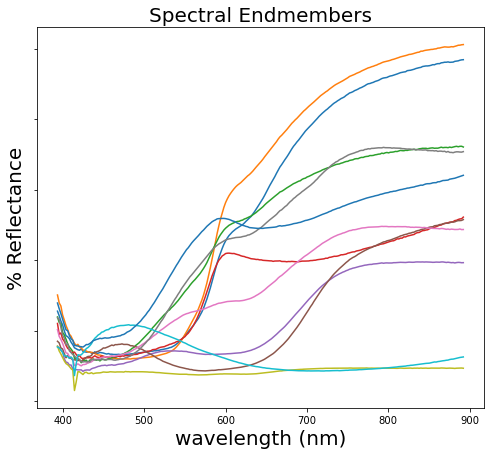

In [24]:
#Plot new spectral endmembers

%matplotlib inline 
fig,ax = plt.subplots(1,figsize=(8,7))
ax.set_title('Spectral Endmembers', size = 20)
ax.plot(wavelength, end_members_b)
ax.set_ylabel('% Reflectance', size=20)
ax.set_xlabel('wavelength (nm)', size=20)
ax.set_yticklabels([]) # Turn off tick labels

plt.show()

In [25]:
#Save endmembers extracted in a csv format

np.savetxt('\\path\\file name.csv',end_members,delimiter=' ')

In [26]:
#perform NNLS on whole original data stack

Ends_b = np.array([nnls(end_members_b,i)[0] for i in tot_unfolded.transpose()]).transpose()
np.shape(Ends_b)

(11, 1590292)

In [27]:
#Visualize new pigment distribution maps and associated reflectance curve

End_maps_b = np.reshape(Ends_b,(np.shape(Ends_b)[0],np.shape(images)[1],np.shape(images)[2]))
%matplotlib inline 
def f(ends_b):
    fig, axarr = plt.subplots(1,3,figsize=(20,10))
    
    axarr[0].imshow(img_RGB)
    axarr[0].set_title('RGB from spectral stack')
    axarr[0].axes.get_xaxis().set_visible(False)
    axarr[0].axes.get_yaxis().set_visible(False)
    
    axarr[1].imshow(End_maps_b[ends_b-1], interpolation='nearest',cmap='gray', vmin = 0)
    axarr[1].set_title('endmember ' + str(ends_b))
    axarr[1].axes.get_xaxis().set_visible(False)
    axarr[1].axes.get_yaxis().set_visible(False)
    
    axarr[2].plot(wavelength, end_members_b[:,ends_b-1])
    axarr[2].set_ylabel('% Reflectance', size=20)
    axarr[2].set_xlabel('wavelength (nm)', size=20)
    axarr[2].set_yticklabels([]) # Turn off tick labels
    axarr[2].set_ylim(np.amin(end_members), np.amax(end_members)) #set y limits if desired
   

    plt.show()

interactive_plot = interactive(f, ends_b=(1, len(end_members_b.transpose()+1)))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=6, description='ends_b', max=11, min=1), Output()), _dom_classes=('widge…

In [29]:
#Save new pigment distribution maps in a txt format

np.savetxt("\\path\\file name.txt",Ends_b,delimiter=' ')